## Fine-Grained ABSA / Aspect Based Emotion Analysis on Twitter Data

<hr>

- Make sure the <span style="color: blue;">parameters</span> below are set correctly.
- Using this notebook assumes you have <span style="color: blue;">cloned</span> the 'sentiment analysis' repo. 
- The grace_files location should include all .py files ("ate_asc_features.py", etc) and the <span style="color: blue;">downloaded bert-base-uncased</span>.

In [56]:
# Your Stuff
path_to_your_CSV_data = 'twitter_takeover_100.csv'
delimiter = ','
columns=['message_id', 'date','text','place','geom'] # add any other columns to the list that should be included in the df and final output file
device='cpu' # alternatively 'cuda'

# GRACE Stuff
model_file = 'GRACE/trained_GRACE_emotion/pytorch_model.bin.9' # path to the location of the model's last checkpoint
grace_files = 'GRACE/' # path to where all the .py files from the GRACE model are located

<hr>

### Aspect-Based Emotion Analysis

##### 0. Set Parameters

In [57]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append(grace_files)

import torch
import os
from ate_asc_modeling_local_bert_file import BertForSequenceLabeling
import ate_asc_modeling_local_bert_file
from file_utils import PYTORCH_PRETRAINED_BERT_CACHE
from ate_asc_features import ATEASCProcessor, convert_examples_to_features, get_labels
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tokenization import BertTokenizer
import argparse
import random
import time
import numpy as np
import torch.nn.functional as F

import csv
import urllib.request
import pandas as pd                                                    # data handling
import xml.etree.cElementTree as ET                                    # XML file parsing

import matplotlib.pyplot as plt
%matplotlib inline

import mapclassify                                                     # required for animated scatterplot map (plotly)
import geopandas as gpd                                                # geographic data handling
import folium                                                          # interactive mapping capabilities
import folium.plugins as plugins
#import plpygis                                                         # a converter to and from the PostGIS geometry types, WKB, GeoJSON and Shapely formats
#from plpygis import Geometry
from shapely.geometry import Point, Polygon, shape                     # creating geospatial data
from shapely import wkb, wkt                                           # creating and parsing geospatial data
import shapely                                                  

import plotly
import plotly.express as px                                            # for interactive, animated timeseries map
import seaborn as sns; sns.set(style="ticks", color_codes=True)
# import json

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from PIL import Image    # for masking wordcloud with an image
import requests          # for accessing url image
from io import BytesIO   # for accedssing url image

# world centroids
# https://github.com/gavinr/world-countries-centroids/blob/master/dist/countries.csv
world = pd.read_csv('https://raw.githubusercontent.com/gavinr/world-countries-centroids/master/dist/countries.csv')

In [58]:
# args set as per instructions by authors
args = argparse.Namespace(

    ## Required parameters
    data_dir='GRACE/data/', 
    bert_model='bert-base-uncased',
    init_model=None,
    task_name="ate_asc",
    data_name="twemlab_all", # initial parameter - will be changed later
    train_file=None,
    valid_file=None,
    test_file=None,
    output_dir='out_testing/', 
    
    ## Other parameters
    cache_dir="",
    max_seq_length=128,
    do_train=False,
    do_eval=False, 
    do_lower_case=True, 
    train_batch_size=32, 
    gradient_accumulation_steps=1,
    eval_batch_size=32,
    learning_rate=3e-06,
    num_train_epochs=10, 
    warmup_proportion=0.1, 
    num_thread_reader=0, 
    no_cuda=False, 
    local_rank=-1, 
    seed=42, 
    fp16=False,
    loss_scale=0,
    verbose_logging=False, 
    server_ip='',
    server_port='', 
    use_ghl=True, 
    use_vat=False, 
    use_decoder=True, 
    num_decoder_layer=2, 
    decoder_shared_layer=3)

# ------------------------------

# seed value setting

random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)  # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# ------------------------------

# device and gpu parameters

#device = 'cuda' # else 'cpu'
n_gpu = 0
data_name = args.data_name.lower()

# ------------------------------

task_name = args.task_name.lower()
task_config = {
    "use_ghl": True,
    "use_vat": False,
    "num_decoder_layer": 2,
    "decoder_shared_layer": 3,
}


##### 1. Load Model and Functions for Validation/ Evaluation 

The GRACE Model is loaded from last training epoch and step:

log messages from last training step and epoch: <br>

```
Model saved to out_twt1_ateacs\pytorch_model.bin.9
AT p:0.7400	r:0.7640	f1:0.7518
AS p:0.5543	r:0.5723	f1:0.5631
```

The function first creates an **ATEASCProcessor object**, which is a custom class for processing the input data and creating examples. It then converts the examples into **features** using the convert_examples_to_features function.

Next, the function creates several PyTorch tensors containing the input data and labels for the validation or evaluation set. These tensors are used to create a **TensorDataset object**, which is a PyTorch dataset containing the input data and labels.

Finally, the function creates a PyTorch dataloader for the validation or evaluation set using the SequentialSampler and DataLoader classes. The dataloader batches the data and returns it to the caller, along with the entire eval_data dataset.

In [59]:
def dataloader_val(args, tokenizer, file_path, label_tp_list, set_type="val"):
    '''
    args: A namespace object containing program arguments.
    tokenizer: A tokenizer object used to tokenize the input data.
    file_path: The path to the file containing the validation or evaluation data.
    label_tp_list: A list of tuples containing the names of the aspect and sentiment labels.
    set_type: A string indicating whether the dataloader is being created for validation or evaluation data (default is "val").
    '''

    dataset = ATEASCProcessor(file_path=file_path, set_type=set_type)
    print("Loaded val file: {}".format(file_path))

    eval_features = convert_examples_to_features(dataset.examples, label_tp_list,
                                                 args.max_seq_length, tokenizer, verbose_logging=False)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_at_label_ids = torch.tensor([f.at_label_id for f in eval_features], dtype=torch.long)
    all_as_label_ids = torch.tensor([f.as_label_id for f in eval_features], dtype=torch.long)

    all_label_mask = torch.tensor([f.label_mask for f in eval_features], dtype=torch.long)
    all_label_mask_X = torch.tensor([f.label_mask_X for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_at_label_ids, all_as_label_ids,
                              all_label_mask, all_label_mask_X)

    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    return eval_dataloader, eval_data

In [60]:
# load bert tokenizer (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

04/17/2023 14:21:58 - INFO - tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\Christina\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [61]:
DATASET_DICT={}
DATASET_DICT["twemlab_all"] = {"train_file":"twemlab_all_train.txt", "valid_file":"twemlab_all_trial.txt", "test_file":"twemlab_all_test.gold.txt"}
DATASET_DICT["lap"] = {"train_file":"laptops_2014_train.txt", "valid_file":"laptops_2014_trial.txt", "test_file":"laptops_2014_test.gold.txt"}
DATASET_DICT["res"] = {"train_file":"restaurants_union_train.txt", "valid_file":"restaurants_union_trial.txt", "test_file":"restaurants_union_test.gold.txt"}
for i in ["2014", "2015", "2016"]:
    DATASET_DICT["res{}".format(i)] = {"train_file": "restaurants_{}_train.txt".format(i), "valid_file": "restaurants_{}_trial.txt".format(i), "test_file": "restaurants_{}_test.gold.txt".format(i)}
for i in range(10):
    DATASET_DICT["twt{}".format(i+1)] = {"train_file":"twitter_{}_train.txt".format(i+1), "valid_file":"twitter_{}_test.gold.txt".format(i+1), "test_file":"twitter_{}_test.gold.txt".format(i+1)}

# check that the current arguments for the train, valid and test files are in the dictionary
if data_name in DATASET_DICT:
    args.train_file = DATASET_DICT[data_name]["train_file"]
    args.valid_file = DATASET_DICT[data_name]["valid_file"]
    args.test_file = DATASET_DICT[data_name]["test_file"]
else:
    assert args.train_file is not None
    assert args.valid_file is not None
    assert args.test_file is not None

# confirm with file is currently set for the training file ("twitter_1_train.txt")
file_path = os.path.join(args.data_dir, args.train_file)
print(file_path)

GRACE/data/twemlab_all_train.txt


In [62]:
# ATEASCProcessor reads data and splits it into corpus and label list for ATE and ASC
dataset = ATEASCProcessor(file_path=file_path, set_type="train")
at_labels, as_labels = get_labels(dataset.label_tp_list)
label_tp_list = (at_labels, as_labels)

print("AT Labels are:", "["+", ".join(label_tp_list[0])+"]")
print("AS Labels are:", "["+", ".join(label_tp_list[1])+"]")
at_num_labels = len(label_tp_list[0])
as_num_labels = len(label_tp_list[1])
num_tp_labels = (at_num_labels, as_num_labels)

task_config["at_labels"] = label_tp_list[0]

# create dicts from labels
at_label_list, as_label_list = label_tp_list
at_label_map = {i: label for i, label in enumerate(at_label_list)}
as_label_map = {i: label for i, label in enumerate(as_label_list)}

AT Labels are: [O, B-AP, I-AP]
AS Labels are: [O, anger, fear, happiness, sadness]


In [63]:
def load_model(model_file, args, num_tp_labels, task_config, device):
    model_file = model_file
    if os.path.exists(model_file):
        model_state_dict = torch.load(model_file, map_location='cpu')
        print("Model loaded from %s", model_file)
        model = BertForSequenceLabeling.from_pretrained(args.bert_model, cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
                                                        state_dict=model_state_dict, num_tp_labels=num_tp_labels,
                                                        task_config=task_config)
        model.to(device)
    else:
        model = None
    return model

In [64]:
# set model file to the last saved model after training epochs completed

# CODE CHANGE NOTE: In this implementation (using a docker container for jupyter lab) the download of bert-base-uncased.tar.gz 
#into cache terminates before the whole file is successfully loaded. 
# Therefore an adapted ate_asc_modeling_local_bert_file.py is imported here which loads the model from a folder in the repo ('bert-base-uncased/bert-base-uncased.tar.gz')

model = load_model(model_file, args, num_tp_labels, task_config, device)

if hasattr(model, 'module'):
    print('has module')
    model = model.module
    
# print(model)

# set model to eval mode (turn off training features e.g. dropout)
model.eval()

Model loaded from %s GRACE/trained_GRACE_emotion/pytorch_model.bin.9
loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\Christina\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
extracting archive file C:\Users\Christina\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\CHRIST~1\AppData\Local\Temp\tmpop7pnv6w


04/17/2023 14:22:02 - INFO - decoder_module -   loading archive file c:\Users\Christina\source\repos\GRACE_lesson\GRACE\decoder-bert-base


BertForSequenceLabeling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          

##### 2. Load Dataset

In [65]:
df = pd.read_csv(path_to_your_CSV_data, delimiter=delimiter, usecols=columns, encoding='latin1')
# df.head()

##### 3. Re-Format Text Column of the Dataset to match the expected GRACE Input

In [66]:
# text column to list
text_list = list(df['text'])

# input format for GRACE model
addition = ' - - O O O'
convert_to_doc = []

# iteratively apply re-formatting and save to new list
for tweet in text_list:
    words = tweet.split()
    words_with_addition = []
    for word in words:
        new_word = word + addition
        #print(new_word)
        words_with_addition.append(new_word)
    convert_to_doc.append(words_with_addition)

##### 4. Save Reformatted Text to .txt File

In [67]:
# extract the folder path and file name from the file path
folder_path, file_name = os.path.split(path_to_your_CSV_data)

# create a new file name with the old file name inserted in it
new_file_name = os.path.splitext(file_name)[0] + '_reformatted.txt'

# create a new file path with the same folder path and the new file name
reformatted_file_path = os.path.join(folder_path, new_file_name)

with open(reformatted_file_path, mode = "w") as f:
    for tweet in convert_to_doc:
        for word in tweet:
            f.write("%s\n" % word)
        f.write("\n")

##### 5. Run GRACE Model on new .txt File

In [68]:
file_path = reformatted_file_path

DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}

eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, file_path, label_tp_list=label_tp_list, set_type="val")

Loaded val file: twitter_takeover_100_reformatted.txt


In [69]:
pred_aspect_terms = []
pred_aspect_sentiments = []

for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        #temp_11 = []
        temp_12 = []
        #temp_21 = []
        temp_22 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                #temp_11.append(at_label_map[at_label_ids[i][j]])
                temp_12.append(at_label_map[logits[i][j]])
                #temp_21.append(as_label_map[as_label_ids[i][j]])
                temp_22.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_12)
        pred_aspect_sentiments.append(temp_22)

# add new aspect term labels and aspect sentiment labels as columns to dataframe
df['aspect_term_preds'] = pred_aspect_terms
df['aspect_senti_preds'] = pred_aspect_sentiments

##### 6. Extract Aspect Terms and Sentiment Aspects

**Note**

Approx. 0.6% of tweets are discarded in this step since there is a mismatch  between the number of words that are recognised by the GRACE model and the standard text processing in python. This in turn means that it is not possible to exactly align the GRACE output, i.e. the asepct sentiment tokens and the aspect term tokens which are generated for each word, with the corresponding words in the tweet. This mismatch is caused by certain emoji rendering: "🫧"

In [70]:
aspect_terms = []
aspect_sentiments = []

# See 'note' above for details
count_mismatches = 0

for index, row in df.iterrows():
    row_aspect_terms = []
    row_aspect_sentiments = []
    
    # Split the input string into a list of words
    words = row['text'].split()

    aspect_term_preds = row['aspect_term_preds']
    pred_aspect_sentiments = row['aspect_senti_preds']
    
    # if the number of words in the tweet match the number of tokens generated by GRACE,
    # then we can associate each token with a word
    if len(words) == len(aspect_term_preds):
        
        i = 0
        while i < len(words):
            if aspect_term_preds[i] == 'B-AP':
                term = words[i]
                sentiment = pred_aspect_sentiments[i]
                i += 1
                
                while i < len(words) and aspect_term_preds[i] == 'I-AP':
                    term += ' ' + words[i]
                    sentiment += ' ' + pred_aspect_sentiments[i]
                    i += 1
                
                row_aspect_terms.append(term)
                row_aspect_sentiments.append(sentiment)
            else:
                i += 1
        
        aspect_terms.append(row_aspect_terms)
        aspect_sentiments.append(row_aspect_sentiments)
    
    # if the number of words in the tweet doesn't match the number of tokens generated
    # by GRACE, then we cannot guarantee that the tokens with be matched to the correct 
    # words and will instead be discarded to be on the safe side
    else:
        # uncomment the printing block below to see details on which rows are discarded

        # print(f"Original text: {row['text']}")
        # if len(row['aspect_senti_preds']) == len(row['aspect_term_preds']):
        #     print(f"This text contains {len(words)} words.\nHowever, the GRACE model generated {len(row['aspect_senti_preds'])} " +
        #           "tokens for the aspect sentiments and terms.\nDue to this mismatch, it cannot be guaranteed that the tokens will " +
        #           "line up with the words as indended.\nTherefore, this row will be discarded with the labels 'n/a'.")
        # else:
        #     print(f"This text contains {len(words)} words.\nHowever, the GRACE model generated {len(row['aspect_senti_preds'])} " +
        #           "tokens for the aspect sentiments and {len(row['aspect:term_preds'])} tokens for the aspect terms.\nDue to this " +
        #           "mismatch, it cannot be guaranteed that the tokens will line up with the words as indended.\nTherefore, this row " +
        #           "will be discarded with the labels 'n/a'.")            
        # print(' ')

        count_mismatches += 1

        # append a n/a value so that the correct match-up between the rows is not lost
        aspect_terms.append('n/a')
        aspect_sentiments.append('n/a')


df['aspect_terms'] = aspect_terms
df['aspect_sentiments'] = aspect_sentiments
print(f"Successfully extracted aspect terms and sentiments: {len(df) - count_mismatches}. \n{count_mismatches} rows had different words vs token lengths.")


Successfully extracted aspect terms and sentiments: 100. 
0 rows had different words vs token lengths.


##### 7. Drop irrelevant Columns from Dataset

In [71]:
df = df.drop(['aspect_senti_preds', 'aspect_term_preds'], axis=1)

##### 8. Export Dataset to new .csv File

In [72]:
# extract the folder path and file name from the file path
folder_path, file_name = os.path.split(path_to_your_CSV_data)

# create a new file name with the old file name inserted in it
final_file_name = os.path.splitext(file_name)[0] + '_ABEA.csv'

# create a new file path with the same folder path and the new file name
final_file_path = os.path.join(folder_path, final_file_name)

# save to CSV
df.to_csv(final_file_path, index=False)


##### 9. View some Rows of the Dataset

In [73]:
df.tail(30)

,message_id,date,text,place,geom,aspect_terms,aspect_sentiments
70,1.593460e+18,18/11/2022 04:41,@__ZB___ wait what happened i havenÂt been on...,"Weatherford, TX","POLYGON ((-97.83979100000001 32.716432, -97.83...",[],[]
71,1.578940e+18,09/10/2022 02:44,@JudicialWatch @elonmusk @Twitter Liar,"Elk Grove, CA","POLYGON ((-121.487576 38.361325, -121.487576 3...",[],[]
72,1.588330e+18,04/11/2022 00:34,Truth it would break Twitter.....@WriterRAS @C...,"Shelbyville, TN","POLYGON ((-86.493835 35.443601, -86.493835 35....",[],[]
73,1.587990e+18,03/11/2022 02:25,I need to stop liking these tweets I don't wan...,"Shelby, NC","POLYGON ((-81.611574 35.237295, -81.4606760000...","[these, tweets]","[anger, anger]"
74,1.587990e+18,03/11/2022 02:08,I upgraded from the iPhone 12 Pro to the iPhon...,"Pasadena, CA","POLYGON ((-118.198346 34.117025, -118.198346 3...","[iPhone 12, iPhone 14, camera., 48 megapixel, ...","[sadness sadness, sadness sadness, sadness, sa..."
75,1.585140e+18,26/10/2022 05:09,@Sapphykinz Twitter algorithm strikes again ht...,"Harrisonville, MO","POLYGON ((-94.37985999999999 38.63171, -94.379...",[Twitter algorithm],[O O]
76,1.592330e+18,15/11/2022 01:14,Drunk/high Twitter? Lol @CaseyNewton https://t...,"Las Vegas, NV","POLYGON ((-115.384091 36.129459, -115.384091 3...",[],[]
77,1.593830e+18,19/11/2022 05:06,@s1mply @SCUBADi22104765 @hodgetwins @elonmusk...,"Rosenberg, TX","POLYGON ((-95.835024 29.482424, -95.835024 29....",[],[]
78,1.581240e+18,15/10/2022 11:10,Twitter finally gets something right https://t...,"Dobbs Ferry, NY","POLYGON ((-73.88355300000001 40.998332, -73.88...",[Twitter],[O]
79,1.591010e+18,11/11/2022 10:12,Verifying my Twitter account for my #GalxeID g...,"Ceres, CA","POLYGON ((-120.993774 37.561491, -120.993774 3...",[#GalxeID],[O]


### Geospatial Analysis

##### 10. De-Tangling Lists of Aspect Tokens

In order to work with the aspects and their emotions, the current df needs to be restructured so that only one aspect term and one emotion are contained in each row. 

In [74]:
def remove_duplicate_words(df, column_name):
    """
    Removes duplicate words from a column in a DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame to operate on.
        column_name (str): The name of the column to remove duplicates from.
    
    Returns:
        pandas.DataFrame: A new DataFrame with the specified column modified.
    """
    new_df = df.copy()  # create a copy of the original DataFrame to avoid modifying it directly
    
    # split the column into separate words using spaces as delimiters
    word_lists = new_df[column_name].str.split(' ')
    
    # check if each list contains more than one word and if the words are all the same
    for i, words in enumerate(word_lists):
        if len(words) > 1 and all(word == words[0] for word in words):
            word_lists[i] = [words[0]]  # replace the list with a new list containing only one word
    
    # join the lists back into strings and assign the modified column back to the DataFrame
    new_df[column_name] = word_lists.str.join(' ')
    
    return new_df

In [75]:
# create a list of dictionaries, where each dictionary corresponds to one item in the aspect_terms and aspect_sentiments lists
rows = []
for i, row in df.iterrows():
    for j in range(len(row['aspect_terms'])):
        rows.append({
            'date': row['date'],
            'text': row['text'],
            'place': row['place'],
            'geom': row['geom'],
            'aspect_terms': row['aspect_terms'][j],
            'aspect_sentiments': row['aspect_sentiments'][j]
        })

# create a new DataFrame from the list of dictionaries
new_df = pd.DataFrame(rows)

aspect_df = remove_duplicate_words(new_df, 'aspect_sentiments')


In [76]:
aspect_df.tail()

,date,text,place,geom,aspect_terms,aspect_sentiments
111,07/10/2022 22:07,Reason #33 not to vote for @LeeZeldin -too ext...,"Baldwin Harbor, NY","POLYGON ((-73.617199 40.621497, -73.617199 40....",@LeeZeldin,O
112,20/11/2022 04:15,"Sorry to tell ya, but free speech is not back ...","Pike Creek, DE",POINT (-75.7043524 39.726849),free speech,anger
113,05/11/2022 02:34,@zeyguy @Hankerella_ @EugeneMirman He should m...,"Hayden, ID","POLYGON ((-116.832204 47.741683, -116.832204 4...",He,O
114,20/11/2022 19:36,@elonmusk I guess these results donÂt really ...,"Seattle, WA","POLYGON ((-122.436232 47.495315, -122.436232 4...",Twitter,anger
115,26/10/2022 02:51,Twitter needs to grant me a verification badge...,"Lafayette, IN","POLYGON ((-86.92488 40.339754, -86.92488 40.47...",Twitter,O


##### 11. Defining some Helper-Functions

In [77]:
# turn normal dataframe with 'geom' column into a geodataframe

from shapely import wkt

def generate_geodataframe(df):

    df['geometry'] = df['geom'].apply(wkt.loads)
    
    # create geopandas GeoDataFrame
    df_geo = gpd.GeoDataFrame(df, crs="EPSG:4326")
    s = gpd.GeoSeries(df_geo['geometry'])
    df_geo['geom'] = df_geo['geometry']
    df_geo['geometry'] = df_geo['geom'].to_crs('epsg:3785').centroid.to_crs(df_geo.crs)
    
    return df_geo

In [78]:
def create_wordclouds_emotions(df, labels_col, labels):
    '''
    Input:
        df: dataframe, requires 'text' column and 'sentiment_label' column with values 'positive', 'negative'
        labels_col: column with textual sentiment labels
        labels: list of textual labels
    Output:
        n/a  (creates wordcloud visualisations)
    '''
    # split into emotions
    happiness = df[df[labels_col] == labels[0]]
    anger = df[df[labels_col] == labels[1]]
    fear = df[df[labels_col] == labels[2]]
    sadness = df[df[labels_col] == labels[3]]
    # other = df[df[labels_col] == labels[4]]

    # create list for the dfs to be added (if they have any rows)
    senti_dfs = []
    # list for the according color schemes for the wordcloud
    # colors available at https://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.pdf
    cmap = []
    # list for the current names of the df to be printed along with the wordclouds
    names = []

    if len(happiness) > 0:
        senti_dfs.append(happiness)
        cmap.append('YlGn')
        names.append('Happiness:')
    if len(anger) > 0:
        senti_dfs.append(anger)
        cmap.append('OrRd')
        names.append('Anger:')
    if len(fear) > 0:
        senti_dfs.append(fear)
        cmap.append('Purples')
        names.append('Fear:')
    if len(sadness) > 0:
        senti_dfs.append(sadness)   
        cmap.append('PuBu') 
        names.append('Sadness:')


    stopwords = set(STOPWORDS)
    stopwords.update(['https', 't', 'co', 's'])
    url = 'https://raw.githubusercontent.com/rasbt/datacollect/master/dataviz/twitter_cloud/twitter_mask.png'
    response = requests.get(url)
    mask = np.array(Image.open(BytesIO(response.content)))

    for i in range(len(senti_dfs)):
        print(names[i])
        text = " ".join(i for i in senti_dfs[i].text)
        wordcloud = WordCloud(stopwords=stopwords, mask=mask, background_color="white", colormap=cmap[i]).generate(text)
        plt.figure( figsize=(10,7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [79]:
def create_df_for_time_chart_three_labels(df, time_interval, labels_col, labels):
    '''
    Input:
        df: dataframe
        time_interval: string, name of column in df that contains time references ('Day', 'Week', 'Month', 'Year')
        labels_col: column with textual sentiment predictions
        labels: list of the textual labels ordered in good to bad e.g. ['Positive', 'Negative', 'Neutral'] or ['positive', 'negative', 'neutral']
    Outout:
        sorted_df: a dataframe with the columns 'month', 'Counts', 'Sentiments'
        fig: the prepared timeseries chart
    '''
    # create relevant datetime column if not already there 
    #if 'time_interval not in df.columns:
    time = time_interval[0]
    df['time_interval'] = [pd.to_datetime(x).to_period(time) for x in df['date']]
    
    # get a list of all the time steps 
    #if time_interval.lower() == 'month':
     #   unique_intervals_in_df = df.Month.unique()
    #elif time_interval.lower() =='day':
#        unique_intervals_in_df = df.Day.unique()
#    elif time_interval.lower() =='year':
#        unique_intervals_in_df = df.Year.unique()
#    elif time_interval.lower() =='week':
#        unique_intervals_in_df = df.Week.unique()

    unique_intervals_in_df = df.time_interval.unique()
    
    # split into pos, neu, neg dfs
    positives = data_subset[data_subset[labels_col] == labels[0]]
    neutrals = data_subset[data_subset[labels_col] == labels[1]]
    negatives = data_subset[data_subset[labels_col] == labels[2]]

    # count how many tweets there are for each time step in each sentiment df
    counts_pos = positives['time_interval'].value_counts()
    counts_neu = neutrals['time_interval'].value_counts()
    counts_neg = negatives['time_interval'].value_counts()

    dfs = [counts_pos, counts_neu, counts_neg]

    d = []
    # iterate over the labels
    for i in range(len(labels)):
        # iterate over all unique time stamps in dataset
        for interval in unique_intervals_in_df:
            # if the current time stamp is in the current label's df
            if interval in dfs[i]:
                # add the time stamp, the count of tweets at that time step , and the label to the output list 'd'
                d.append([interval, dfs[i][interval], labels[i]])

    # create a df from information
    intervals_df = pd.DataFrame(d, columns=['time_interval', 'Counts', 'Sentiment']) 
    
    # sort by time
    sorted_df = intervals_df.sort_values(by=['time_interval'])

    # reformat to string for display
    sorted_df['time_interval'] = sorted_df['time_interval'].values.astype(str)
    
    # create figure
    fig = px.area(sorted_df, 
                  x= "time_interval", 
                  y="Counts", 
                  color="Sentiment", 
                  line_group='Sentiment',
                  hover_name="Counts",
                  color_discrete_map={labels[0]:'#0DB110', labels[1]: '#F7E444', labels[2]: '#DD2828'})

    return sorted_df, fig

In [80]:
def create_animated_time_map_three_labels(df, time_interval, label_col, title, labels, style):
    '''
    inputs: 
        df: geodataframe (needs to have a 'geometry' column)
        time_interval: a timestamp column (e.g. 'Day') - must be capitalised
        label: the df column used for the main label on the tooltip popup
        title: string 
        n_labels: int
        color_discrete_map: dict, mapping labels e.g. 'negative' to colors e.g. '#FF0000'
        style: string, mapbox styles e.g. 'carto-positron', 'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 
              'stamen- terrain', 'stamen-toner', 'stamen-watercolor', 'basic', 'streets', 'outdoors', 'light', 
              'dark', 'satellite', 'satellite- streets'
    output:
        plotly interactive, animated map
    '''
    
    if time_interval not in df.columns:

        time = time_interval[0]
        df['time_interval'] = [pd.to_datetime(x).to_period(time) for x in df['date']]
    
    # set colors for markers
    cmap = {labels[0]: '#62FF00', labels[1]: '#FCFF00', labels[2]: '#FF0000'}
    
    fig = px.scatter_geo(df,
              lat=df.geometry.y,
              lon=df.geometry.x,
              size = [0.5] * len(df),
              size_max = 8,
              hover_name = label_col,
              hover_data = ['date'],
              color = label_col,
              color_discrete_map = cmap,
              animation_frame= 'time_interval',
              #mapbox_style=style,
              #category_orders={
              #time_col:list(np.sort(df[time_col].unique()))
              #},                  
              #zoom=3,
              opacity = 0.6,
              projection = 'albers usa',
              #projection= 'orthographic',
              #scope= 'north america',
              width=1600,
              height=1000)
                       
    
    fig.update_layout(
        title=title,
        autosize= True,
        hovermode='closest',
        margin=dict(t=0, b=0, l=0, r=0)
    )
    
    fig.show();
            
    return


In [81]:
def create_folium_map(in_df, map_center, tiles, zoom_start, n_labels, text_col, senti_label_col):
    '''
    Input: 
        df: a geodataframe (must have 'geometry' column)
        map_center: a string country name, or a list with two coordinates e.g. [37.0902, -95.7129]
        tiles: stirng, the background map style e.g. 'cartodbpositron' or 'Stamen Toner'
        zoom_start: int, higher numbers a more zoomed out
        n_labels: int, either two or three
        text_col: string, the name of the tweets text column in the df
        senti_label_col: string, the name of the labels column in the df
    Output:
        map: an interactive folium map
    '''  
    # create copy of df and add column with numerical representation of the labels (used to index into the cmap for coloring)
    df = in_df.copy()
    df['senti_num_label_col'] = 3
    df['senti_num_label_col'][df[senti_label_col] == 'happiness'] = 0
    df['senti_num_label_col'][df[senti_label_col] == 'anger'] = 1
    df['senti_num_label_col'][df[senti_label_col] == 'fear'] = 2
    df['senti_num_label_col'][df[senti_label_col] == 'sadness'] = 3

    df['senti_num_label_col'] = df['senti_num_label_col'].astype(int)

    #senti_num_label_col = 'senti_num_label_col'
    
    # Set map center
    if isinstance(map_center, str):
        # If map_center is a string, try to find its coordinates in a world centroids CSV file
        centroids = pd.read_csv('https://raw.githubusercontent.com/gavinr/world-countries-centroids/master/dist/countries.csv')
        country_row = centroids[centroids['COUNTRY'] == map_center].iloc[0]
        center = [country_row['latitude'], country_row['longitude']]
    else:
        # If map_center is already a list of coordinates, use it as is
        center = map_center

    # Create map with basic settings
    map = folium.Map(location=center, tiles=tiles, zoom_start=zoom_start)

    # create map with basic settings
    # get map's center coordinates from dict, default to usa
    map = folium.Map(location=center, tiles=tiles, zoom_start=zoom_start)
    
    # set colors
    if n_labels == 3:
        cmap = ['#FF0000','#FCFF00','#62FF00']  # red, yellow, green
    elif n_labels == 4:
        cmap = ['#73F178','#F17373','#ac59e5','#2a98ec']
    else: 
        cmap = ['#FF0000','#62FF00'] # red, green    

    # iterate over df rows
    for i in range(0, len(df)):

        # logic to split tweet text for the pop ups (had to be done manually, couldn't find appropriate function included in folium.map.tooltip - html max width only applies to the box)
        text = ''

        # if text is longer than 40 characters, split into words list and count
        if len(df.iloc[i][text_col]) > 40: 
            word_list = df.iloc[i][text_col].split()
            length = len(word_list)

            # first part of text is the same regardless of length
            text_pt1 = '<b>Emotion:</b> ' + df.iloc[i][senti_label_col] + '<br><b>Tweet:</b> '

            k = 0
            text_add = []

            # while k hasn't reached the length of the word list yet, keep adding words to 'text_add' list with a '<br>' after every 6th word
            while k < length:
                # after every 6 words add '<br>'
                if k%6 == 0 and k != 0:
                    text_add.append(str(word_list[k:k+1][0]) + ' <br>')
                else:
                    text_add.append(word_list[k:k+1][0])
                k += 1

            # join 'text_add' list together and then both text parts
            text_pt2 = ' '.join(text_add)
            text = text_pt1 + text_pt2

        else:
            text = '<b>Emotion:</b> ' + df.iloc[i][senti_label_col] + '<br><b>Tweet:</b> ' + df.iloc[i][text_col]

        fill_color_string=cmap[(df.loc[i, 'senti_num_label_col'])],
        fill_color_str = str(fill_color_string).strip("(),'")

        map.add_child(
            folium.CircleMarker(
                location=[df.iloc[i].geometry.y, df.iloc[i].geometry.x],
                radius = 5,
                tooltip= folium.map.Tooltip(text),
                # fill_color=cmap[(df.iloc[i][senti_num_label_col])],
                fill_color = fill_color_str,
                fill_opacity = 0.4,
                stroke=False
            )
        )


    # add button for full screen
    # folium.plugins.Fullscreen().add_to(map)
    
    return map

In [82]:
def create_piechart(ratios, labels, title):

    #colors
    if len(labels) == 3:
        colors = ['#73F178','#F8FF72', '#F17373']
    elif len(labels) == 2:
        colors = ['#73F178', '#F17373']
    elif len(labels) == 4:
        colors = ['#73F178', '#F17373', '#ac59e5', '#2a98ec']

    #explosion
    explode= [0.05] * len(ratios)

    plt.pie(ratios, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
   # ax1.axis('equal')  
    plt.tight_layout()
    plt.show()

##### 12. Plots

In [83]:
# the labels that we want to feature in the piechart, i.e. the emotions
labels = ['happiness', 'anger', 'fear', 'sadness']

Count of Aspect-related Emotions:
Happiness: 0
Anger: 33
 Fear: 2
Sadness: 38



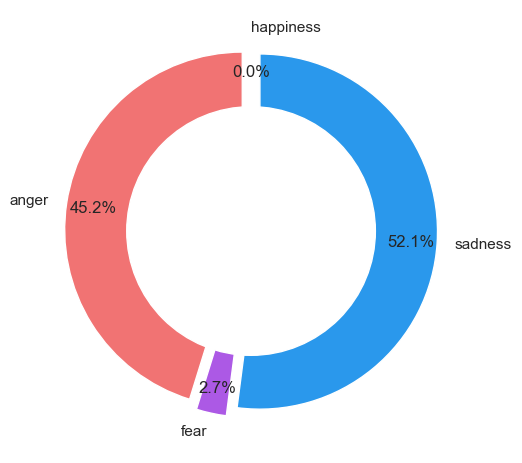

In [84]:
# count label frequencies and save in list
happiness = list(aspect_df['aspect_sentiments']).count(labels[0])
anger = list(aspect_df['aspect_sentiments']).count(labels[1])
fear = list(aspect_df['aspect_sentiments']).count(labels[2])
sadness = list(aspect_df['aspect_sentiments']).count(labels[3])
ratios = [happiness, anger, fear, sadness]

print(f"Count of Aspect-related Emotions:\nHappiness: {ratios[0]}\n" +
      f"Anger: {ratios[1]}\n "+
      f"Fear: {ratios[2]}\n" +
      f"Sadness: {ratios[3]}\n")

# create simple piechart to show ratios between the sentiment labels
create_piechart(ratios, labels=labels, title='Emotions in Covid-Related Tweets')

Anger:


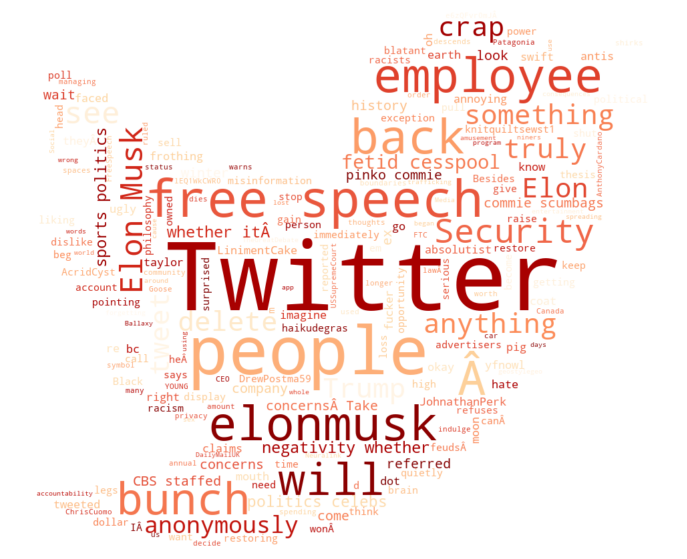

Fear:


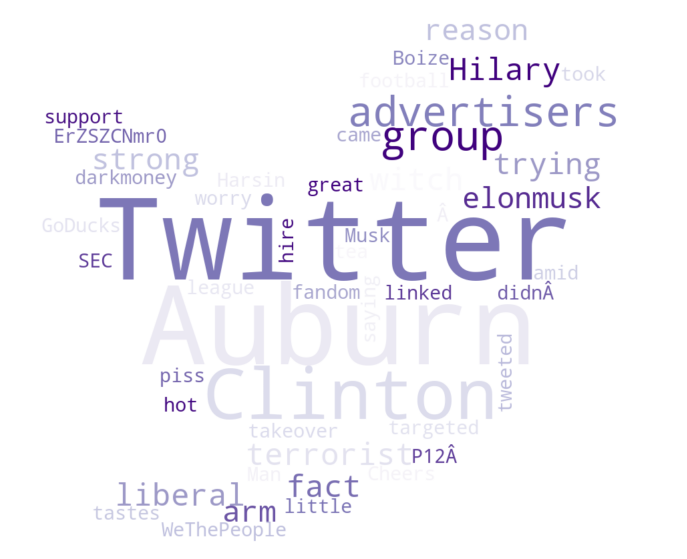

Sadness:


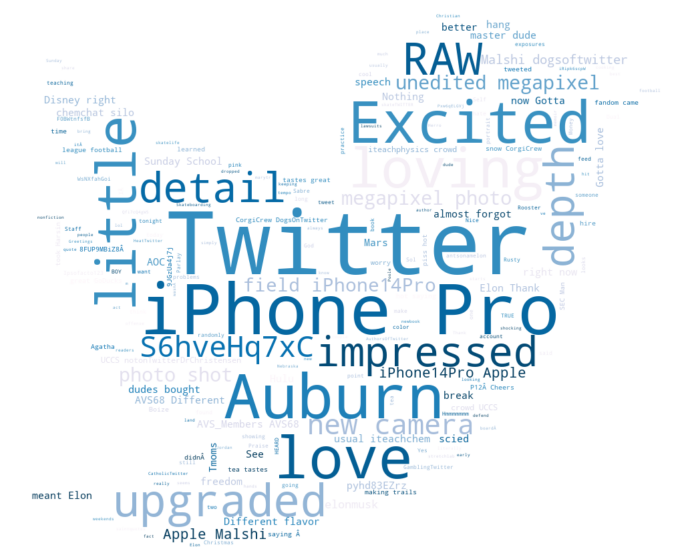

In [85]:
create_wordclouds_emotions(df=aspect_df, labels_col='aspect_sentiments', labels=labels)

##### 13. Geographic Emotions

In [86]:
# create copy of the dataframe
data_copy = aspect_df.copy()

# convert dataframe to geodataframe using the geom column
data_geo = generate_geodataframe(data_copy)

In [87]:
print(len(data_geo))

116


In [88]:
# create an interactive folium map
# for map center USA is 'United States', UK is 'United Kingdom'

folium_map = create_folium_map(in_df = data_geo, 
                               map_center = 'United States', 
                               tiles = 'cartodbpositron', 
                               zoom_start = 4, 
                               n_labels = 4, 
                               text_col = 'text', 
                               senti_label_col = 'aspect_sentiments'
                              )

# display map
folium_map

C:\Users\Christina\AppData\Local\Temp\ipykernel_5128\2470137977.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['senti_num_label_col'][df[senti_label_col] == 'happiness'] = 0
C:\Users\Christina\AppData\Local\Temp\ipykernel_5128\2470137977.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['senti_num_label_col'][df[senti_label_col] == 'anger'] = 1
C:\Users\Christina\AppData\Local\Temp\ipykernel_5128\2470137977.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin